# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 6: Simulation of Spin-Lock Induced Crossing (SLIC) - DeVience, et.al, PRL 111, 2013.
In this tutorial you will simulate Figure 1 (d) using Pulse sequence given in Figure 1 (c), from the paper "Preparation of Nuclear Spin Singlet States Using Spin-Lock Induced Crossing", by DeVience, et.al, Phys. Rev. Lett. 111, 173002.
DOI: https://doi.org/10.1103/PhysRevLett.111.173002

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2]

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [6]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaH1]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 4.7

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [0,2.8] # Offset frequency in Hz
deltaV = Offset[1] - Offset[0] # Frequency difference between Spin 1 and 2
"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-200.11400882 -200.11401162]


## Initialize Density Matrix

In [7]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = False 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  0j


## Zeeman Halitonian in Rotating Frame

In [8]:
off = -2*np.pi*deltaV/2 
OmegaRF = [-System.gammaH1*B0 + off ,-System.gammaH1*B0 + off] # RF iradiation in the middle of spin frequencies
Hzr = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## J Coupling Hamiltonian

In [9]:
"""
Define J couplings between individual spins
"""

Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][1] = 17.4
Hj = System.Jcoupling(Jlist,Sx,Sy,Sz)

## B1 Hamiltonian (Spin Lock)

In [10]:
Omega1 = [Jlist[0][1],Jlist[0][1]] # SLIC condition: B1 amplitude equals J coupling between two spins
Omega1Phase = [0,0]
Hrf = System.Zeeman_B1(Sx,Sy,Omega1,Omega1Phase)

## Total Hamiltonian

In [11]:
Hslic = Hzr + Hj + Hrf # Hamiltonina duirng Spin Lock
Hevol = Hzr + Hj # Hamiltonian during Free Evolution

## Pulse

In [12]:
"""
Rotate the magnetization about Y-axis, by an angle theta.
""";
pulse_angle = 90.0
rho = System.Rotate_H(rho_in,pulse_angle,np.sum(Sy,axis=0)) 

## Relaxation Constant

In [13]:
'''
Define longitudinal (R1) and transverse Relaxation (R2)
R1 = [R1 of first spin, R1 of second spin,...]
R2 = [R2 of first spin, R2 of second spin,...]
''';

R1 = 1.0
R2 = 2.0
System.Relaxation_Constants(R1,R2)

'''
Options for "Rprocess": "No Relaxation" or "Phenomenological" 
                         or "Random Field Fluxtuation" or "Dipolar"
''';
Rprocess = "No Relaxation"

## Evolution of Density Matrix under first Spin Lock

In [14]:
dt = 50e-6
Slic_Time = 0.707/abs(deltaV)
Npoints1 = int(Slic_Time/dt)
print("Number of points in the simulation", Npoints1)

"""
option for solver, "method": "Unitary Propagator" or "ODE Solver"
"""
method = "Unitary Propagator"

start_time = time.time()
t1, rho_t1 = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hslic,dt,Npoints1,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Number of points in the simulation 5050
Total time = 0.03569293022155762 seconds 


## Evolution of Density Matrix (Free Evolution)

In [15]:
dt = 50e-6
Evol_Time = 0.4
Npoints2 = int(Evol_Time/dt)
print("Number of points in the simulation", Npoints2)

method = "Unitary Propagator"

start_time = time.time()
t2, rho_t2 = System.Evolution_H(rhoeq,rho_t1[-1],Sx,Sy,Sz,Sp,Sm,Hevol,dt,Npoints2,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Number of points in the simulation 8000
Total time = 0.08072781562805176 seconds 


## Evolution of Density Matrix under second Spin Lock

In [16]:
dt = 50e-6
Slic_Time = 0.707/abs(deltaV)
Npoints3 = int(Slic_Time/dt)
print("Number of points in the simulation", Npoints3)

method = "Unitary Propagator"

start_time = time.time()
t3, rho_t3 = System.Evolution_H(rhoeq,rho_t2[-1],Sx,Sy,Sz,Sp,Sm,Hslic,dt,Npoints3,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Number of points in the simulation 5050
Total time = 0.07059264183044434 seconds 


## Expectation value

In [17]:
"""
Zeeman Basis
""";
B_Z = System.ZBasis_H(Hz)

<IPython.core.display.Latex object>

In [18]:
"""
Singlet Triplet Basis
""";
B_ST = System.STBasis(B_Z)

<IPython.core.display.Latex object>

In [19]:
"""
Expectation Value of different Operators
""";

det1 = -np.matmul(B_ST[3],System.Adjoint(B_ST[3])) # |S0><S0|
det2 = -np.matmul(B_ST[1],System.Adjoint(B_ST[1])) # |T0><T0|
det3 = 0.5*(Sz[0] - Sz[1]) # I1z - I2z
det4 = 0.5*(Sx[0] + Sx[1]) # I1x + I2x
det5 = 0.5*(Sy[0] - Sy[1]) # I1y - I2y

In [20]:
t1, det1_a = System.Expectation_H(rho_t1,det1,dt,Npoints1) # First Spin Lock
t2, det1_b = System.Expectation_H(rho_t2,det1,dt,Npoints2) # Free Evolution
t3, det1_c = System.Expectation_H(rho_t3,det1,dt,Npoints3) # Second Spin Lock

t1, det2_a = System.Expectation_H(rho_t1,det2,dt,Npoints1) # First Spin Lock
t2, det2_b = System.Expectation_H(rho_t2,det2,dt,Npoints2) # Free Evolution
t3, det2_c = System.Expectation_H(rho_t3,det2,dt,Npoints3) # Second Spin Lock

t1, det3_a = System.Expectation_H(rho_t1,det3,dt,Npoints1) # First Spin Lock
t2, det3_b = System.Expectation_H(rho_t2,det3,dt,Npoints2) # Free Evolution
t3, det3_c = System.Expectation_H(rho_t3,det3,dt,Npoints3) # Second Spin Lock

t1, det4_a = System.Expectation_H(rho_t1,det4,dt,Npoints1) # First Spin Lock
t2, det4_b = System.Expectation_H(rho_t2,det4,dt,Npoints2) # Free Evolution
t3, det4_c = System.Expectation_H(rho_t3,det4,dt,Npoints3) # Second Spin Lock

t1, det5_a = System.Expectation_H(rho_t1,det5,dt,Npoints1) # First Spin Lock
t2, det5_b = System.Expectation_H(rho_t2,det5,dt,Npoints2) # Free Evolution
t3, det5_c = System.Expectation_H(rho_t3,det5,dt,Npoints3) # Second Spin Lock

## Plotting

<IPython.core.display.Javascript object>


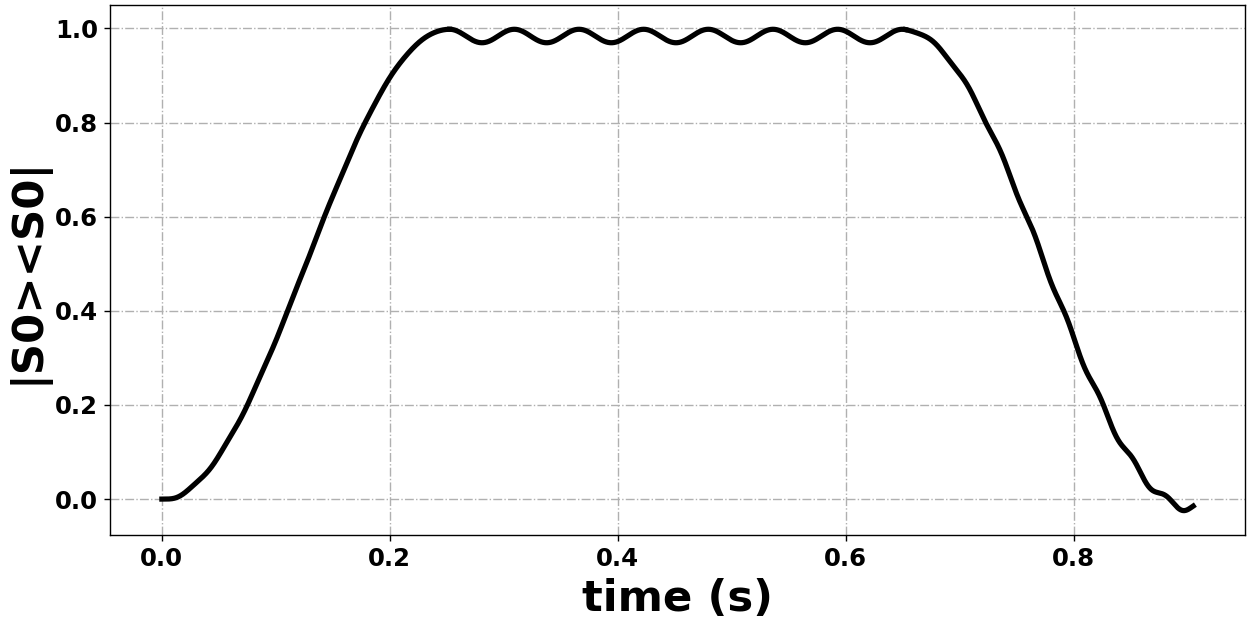

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [21]:
System.PlottingMulti(1,[t1,t1[-1]+t2,t1[-1]+t2[-1]+t3],[det1_a,det1_b,det1_c],"time (s)","|S0><S0|",["black","black","black"])

<IPython.core.display.Javascript object>


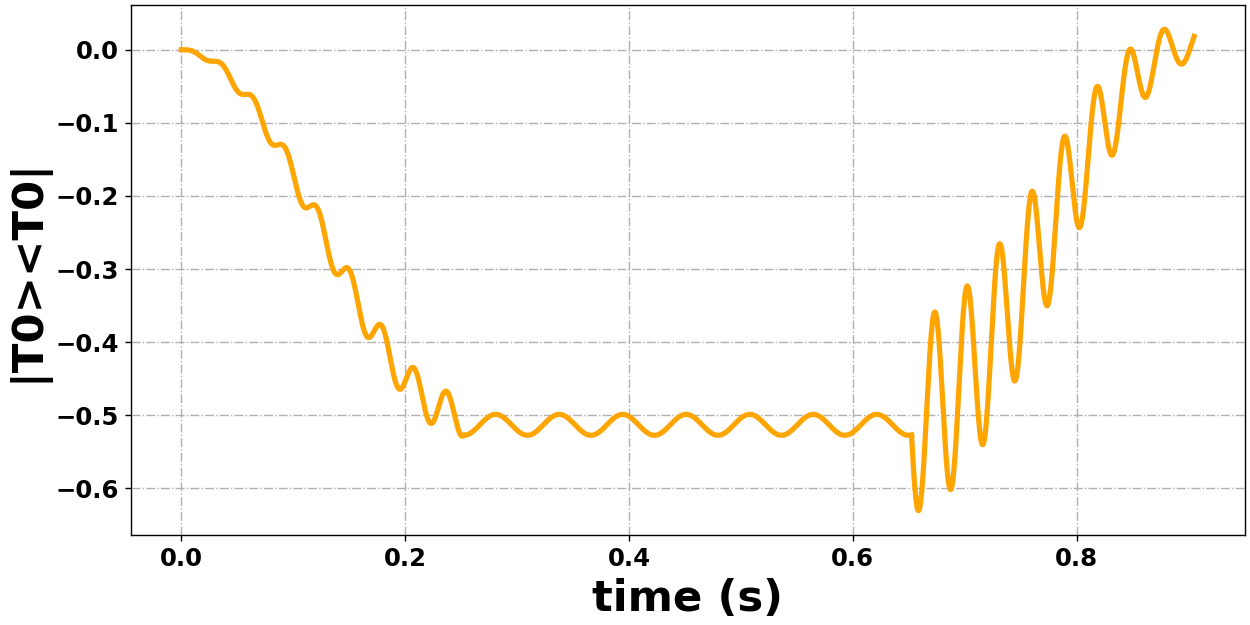

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [22]:
System.PlottingMulti(2,[t1,t1[-1]+t2,t1[-1]+t2[-1]+t3],[det2_a,det2_b,det2_c],"time (s)","|T0><T0|",["orange","orange","orange"])

<IPython.core.display.Javascript object>


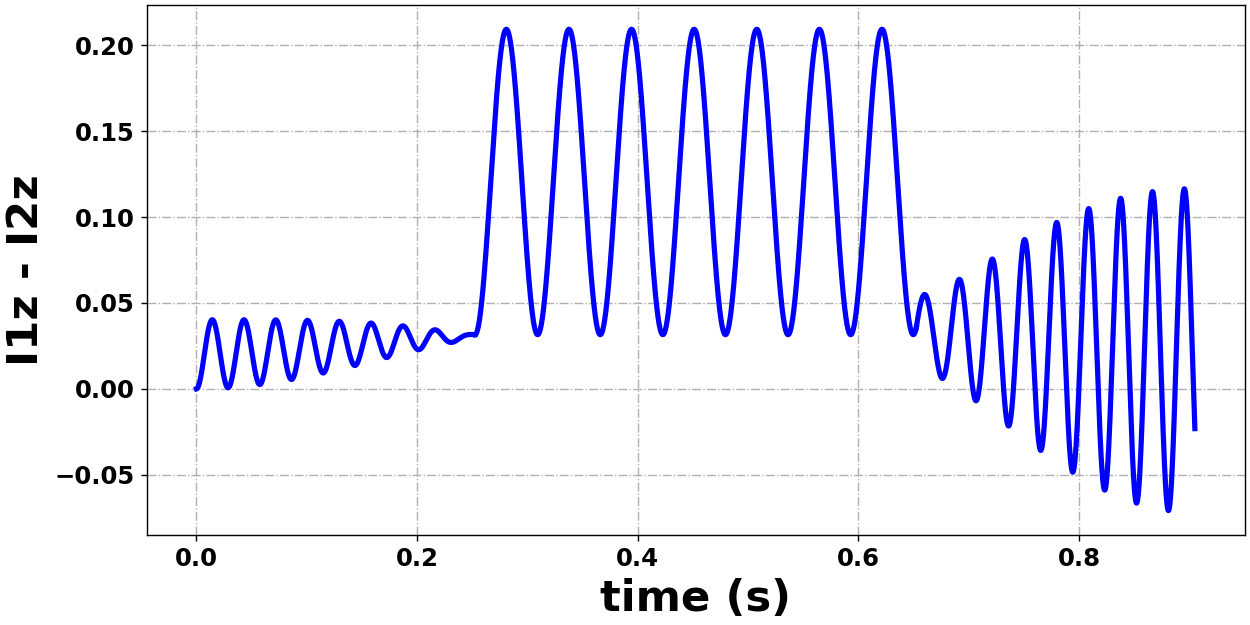

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [23]:
# There is a small difference between this result from the paper
System.PlottingMulti(3,[t1,t1[-1]+t2,t1[-1]+t2[-1]+t3],[det3_a,det3_b,det3_c],"time (s)","I1z - I2z",["blue","blue","blue"])

<IPython.core.display.Javascript object>


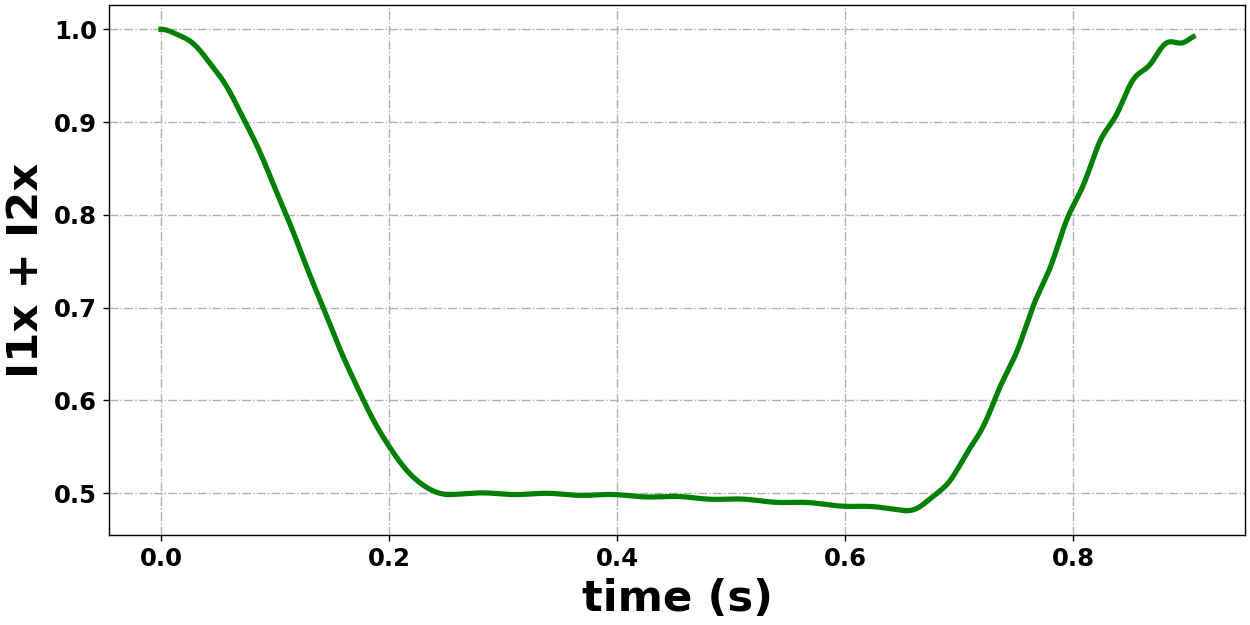

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [24]:
System.PlottingMulti(4,[t1,t1[-1]+t2,t1[-1]+t2[-1]+t3],[det4_a,det4_b,det4_c],"time (s)","I1x + I2x",["green","green","green"])

<IPython.core.display.Javascript object>


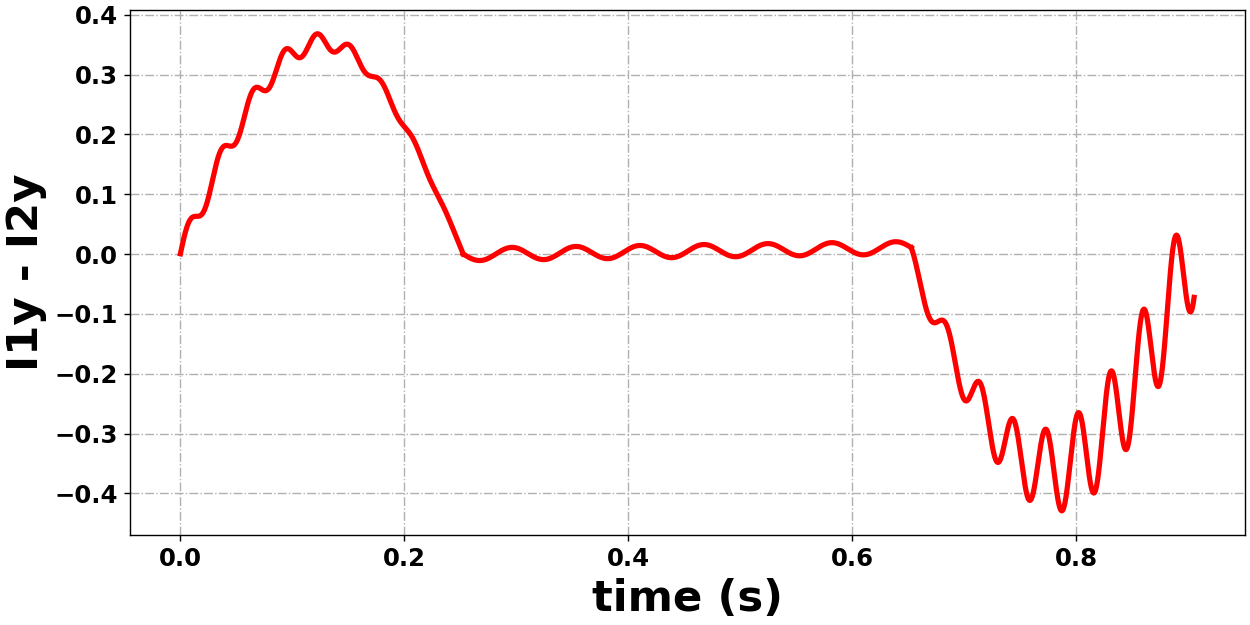

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [25]:
System.PlottingMulti(5,[t1,t1[-1]+t2,t1[-1]+t2[-1]+t3],[det5_a,det5_b,det5_c],"time (s)","I1y - I2y",["red","red","red"])

## Next tutorial: Evolution of Density Matrix in Hilbert Space using ODE Solver and phenomenological Relaxation

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com